# FMR simulation

This notebook shows how to simulate the VNA-type FMR spectra, frequency versus external field for a fixed field angle, of a permalloy rectangular waveguide with 500nmx20nm dimensions. The static external field will be applied along the hard axis.

The sample creation and mesh definition is taken to be known from the previous examples.

In [1]:
import tetrax as tx
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
sample = tx.create_sample(name="FMR_rect_WG_500nmx20nm")
sample.Msat = 800e3
sample.Aex = 13e-12
# Geometry of the rectanguar element, width x thickness
width = 500 # in units defined by the sample.scale
thickness = 20 # in units defined by the sample.scale
lca = 5 # tetrahedron edge length along width
lcb = 5 # tetrahedron edge length along thickness
mesh = tx.geometries.rectangle_cross_section(width,thickness,lca,lcb)
sample.set_geom(mesh)

This sample does not have a mesh yet. You cannot set spatially dependent saturation for it.
This sample does not have a mesh yet. You cannot set spatially dependent exchange stiffness for it.
Setting geometry and calculating discretized differential operators on mesh.
Done.


### Dispersion and absorption calculation in a field loop

In this section we create and experimental setup and set a homogeneous antenna. The external field will be looped between a minimum and maximum value with a given field step. For each static field value the equilibrium magnetization state will be obtained with relaxation. Then the dispersion is calculated for k=0 (FMR or homogeneous modes) only for the first 20 modes. This is followed by the calculation of the absorption, again for k=0. The total absorption is collected into a list that will be converted into a 2D numpy array and finally plotted as a 2D map, x axis being the external static fields, y axis the frequencies.

NOTE: Depending on the sample size, underlaying mesh size, number of modes and number of field steps requested, this simulation can take between several minutes to several hours. Be patient!
Here, we use ```verbose=False``` for the relaxation, dispersion and absorption calculation. We advise you to set to ```True```, or if no argument is set, will by default be true.
To ensure that the equilibrium magnetization is proper, we use a ```while loop``` and give 5 trials for the ```relax()``` function.

In [3]:
Bmin = 0.1 # min. static field value
Bmax = 0.7 # max. static field value
Bstep = -2.5e-3 # field step
exp = tx.create_experimental_setup(sample)
bstatic = tx.vectorfields.homogeneous(sample.xyz, 90, 0)
exp.antenna = tx.core.experimental_setup.HomogeneousAntenna(90,90)

total_absorb = []
ext_fields = np.arange(Bmax,Bmin+Bstep,Bstep)


for Bstat in ext_fields:
    sample.mag = tx.vectorfields.homogeneous(sample.xyz, 60.0, 0.0) # arguments (coordinate, theta, phi)
    exp.Bext = Bstat * bstatic
    nr_trial = 0
    success = False
    while (not(success) and (nr_trial < 5)):
        success = exp.relax(tol=1e-13,continue_with_least_squares=True,verbose=False)
        nr_trial += 1
    dispersion = exp.eigenmodes(num_cpus=-1,num_modes=20,k=0,verbose=False)
    absorb_df = exp.absorption(k=0,verbose=False)
    total_absorb.append(absorb_df["Re(chi)"])
    


Relaxation with SLSQP method method was not successful.


Relaxation with SLSQP method method was not successful.


Relaxation with SLSQP method method was not successful.



<IPython.core.display.Javascript object>


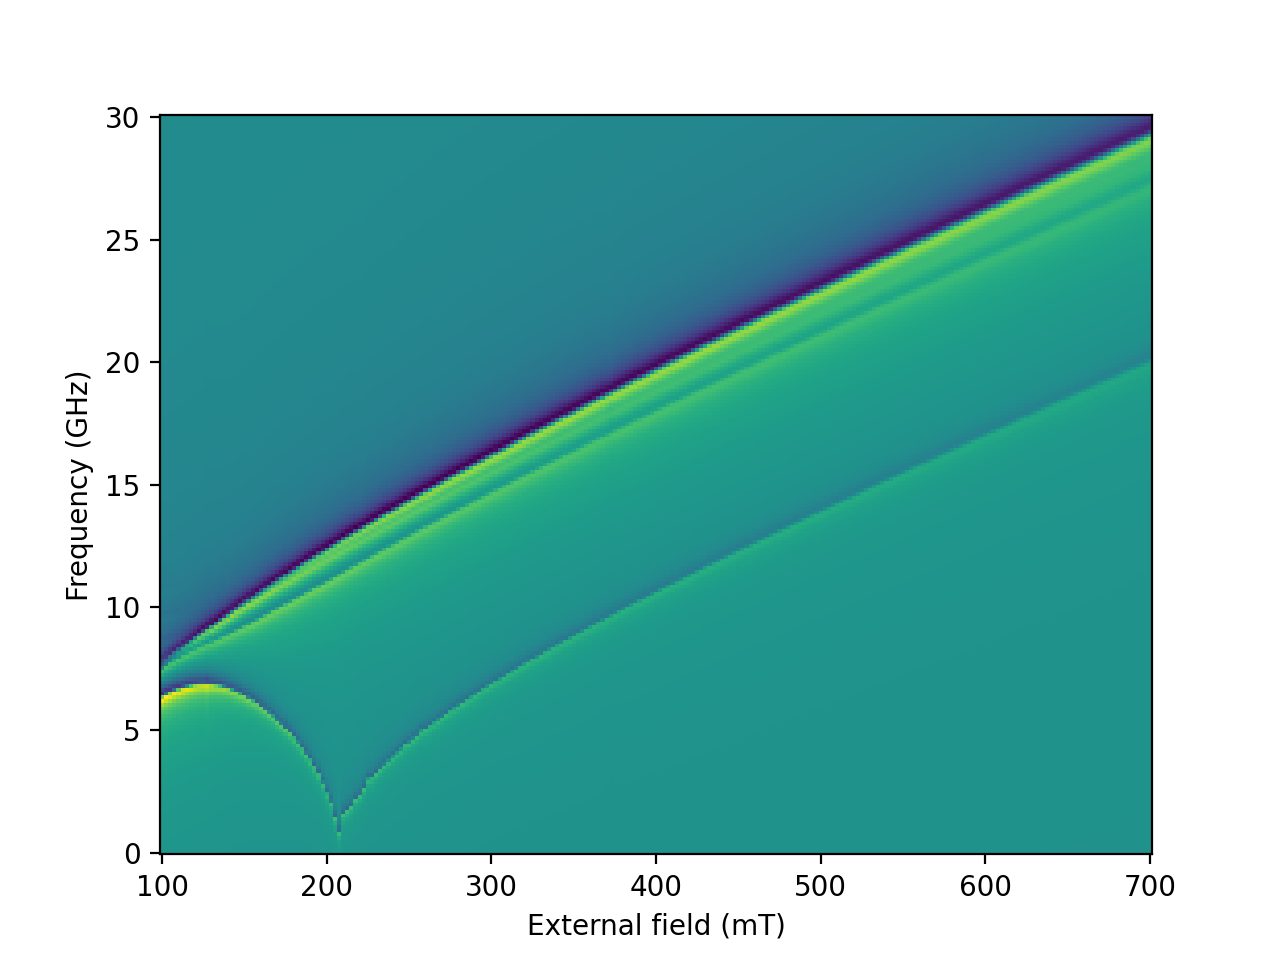

In [4]:
tt_abs = np.array(total_absorb)
bb,ff = np.meshgrid(ext_fields*1e3,absorb_df["RF frequency (GHz)"])
plt.pcolormesh(bb, ff, tt_abs.T)
plt.xlabel("External field (mT)")
plt.ylabel("Frequency (GHz)")
plt.show()

In case in the 2D map for couple of field values the spectra looks wrong, means that the equilibration was not successfull. You might need to rerun for these particular field values. We are currently working on an implementation of a better energy minimization approach.